# ideas

feature engineering
* sequence len
* n-gram frequency, amount of overlap
* sequencing (recurrent)
* group similar labels together
* “ATGC” becomes [0.25, 0.5, 0.75, 1.0] (https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-ml)
* “ATGC” would become [0,0,0,1], [0,0,1,0], [0,1,0,0], [1,0,0,0] (widely used in dep learning methods and lends itself well to algorithms like convolutional neural networks)
* above methods need truncation or padding to ensure equal length

feature selection
* chi sq test, but need less labels
* get rid of correlated features
* group together similar labels
* pca

machine learning
* multiple models, condition prob b/c imbalanced classes
* models to identify most common classes
* over and under sampling
* how to validation: val set, k fold
* ensure not overfitting
* learning curves

# setup

## libraries

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Oct  9 12:25:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump, load
import os
from scipy.sparse import load_npz
from scipy import sparse

%matplotlib inline
sns.set()

In [ ]:
!pip install datatable

     |████████████████████████████████| 83.7MB 37kB/s 


In [ ]:
import datatable as dt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/code/')

In [ ]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
train_frac = .8
DATA_DIR = Path.cwd().parent / 'data/train_frac_{}'.format(int(train_frac*100))

In [ ]:
DATA_DIR

PosixPath('/content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80')

# read in data

## tfidf

In [ ]:
X = load_npz("{}/X_tfidf.npz".format(DATA_DIR))

In [ ]:
pd.Series(X.sum(axis=0).tolist()[0]).describe([.1,.25,.5,.85,.99])

count    55203.000000
mean         6.793603
std        213.097582
min          0.000159
10%          0.010683
25%          0.018800
50%          0.040889
85%          6.407742
99%         61.577895
max      43347.200976
dtype: float64

In [ ]:
keep_cols = [i for i,v in enumerate(X.sum(axis=0).tolist()[0]) if v > 6.4]

In [ ]:
X = X[:,keep_cols]

In [ ]:
X = X.toarray()

In [ ]:
X_val = load_npz("{}/X_val_tfidf.npz".format(DATA_DIR))

In [ ]:
X_val = X_val[:,keep_cols]

In [ ]:
X_val = X_val.toarray()

## read in

In [ ]:
if train_frac == .95:
  train_frac_orig = train_frac
  train_frac = .8

In [ ]:
X = pd.read_csv(DATA_DIR / 'X_pca_prev.csv', header=0)#, index_col=0)
X.shape
# X.to_csv(DATA_DIR / 'X_pca.csv', index=False)

(50413, 12000)

In [ ]:
# X = dt.fread(DATA_DIR / 'X_pca_prev.csv', fill=True, header=False)#, max_nrows=30000)#)
# X = pd.read_csv(DATA_DIR / 'X.csv')
X = X.to_numpy()
X = X[:,:8000]
# X = np.genfromtxt(DATA_DIR / 'X.csv', delimiter=',')
X.shape

(50413, 8000)

In [ ]:
# X_val = pd.read_csv(DATA_DIR / 'X_val.csv')
# X_val.to_csv(DATA_DIR / 'X_val.csv')

In [ ]:
X_val = dt.fread(DATA_DIR / 'X_val_pca_prev.csv', fill=True)#, max_nrows=3000)
X_val = X_val.to_numpy()
X_val = X_val[:,:8000]
# X_val = np.genfromtxt(DATA_DIR / 'X_val.csv', delimiter=',')
X_val.shape

(12604, 8000)

In [ ]:
y = dt.fread(DATA_DIR / 'y.csv')#, max_nrows=30000)
y = y.to_numpy()
y_val = dt.fread(DATA_DIR / 'y_val.csv')#, max_nrows=3000)
y_val = y_val.to_numpy()

In [ ]:
y.shape

(50413, 1314)

In [ ]:
y_val.shape

(12604, 1314)

In [ ]:
np.savetxt("{}/y.csv".format(DATA_DIR), y, delimiter=",")

In [ ]:
np.savetxt("{}/y_val.csv".format(DATA_DIR), y_val, delimiter=",")

### 95% training

In [ ]:
if train_frac_orig == .95:
  train_frac = .95

In [ ]:
n_rows_concat = 59866 - X.shape[0]
X = np.concatenate([X, X_val[:n_rows_concat,:]], axis=0)
X_val = X_val[n_rows_concat:,:]
print(X.shape)

(59866, 8000)


In [ ]:
y = np.concatenate([y, y_val[:n_rows_concat,:]], axis=0)
print(y.shape)
y_val = y_val[n_rows_concat:,:]

(59866, 1314)


## normalize

In [ ]:
x_ser = pd.Series(X.flatten())

In [ ]:
x_ser.describe([.01,.02,.05,.95,.98,.99])

In [ ]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
norm = norm.fit(X)
X = norm.transform(X)

In [ ]:
X_val = norm.transform(X_val)

# hyperparameter tuning

## libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
top_10_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=10)

## custom loss function

In [ ]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [ ]:
@tf.function
def top10_accuracy_scorer(y_true, y_pred, from_logits=False):

    values, indeces = tf.math.top_k(y_pred, 10)
    lab_indeces_tensor = tf.argmax(y_true,1)
    lab_indeces_tensor = tf.reshape(lab_indeces_tensor, 
                                    shape=(tf.shape(lab_indeces_tensor)[0],1))
    lab_indeces_tensor = tf.dtypes.cast(lab_indeces_tensor,dtype=tf.int32)
    equal_tensor = tf.equal(lab_indeces_tensor, indeces)
    
    sum_tensor = tf.reduce_sum(tf.cast(equal_tensor, tf.float32))
    top10_accuracy = sum_tensor/tf.cast(tf.shape(lab_indeces_tensor)[0], tf.float32)
    
    return top10_accuracy

## build model

In [ ]:
def build_model(hp):
  
    #  'optimizer': [Adam, Nadam, RMSprop],
    
    clear_session()
    tf.random.set_seed(0)
    model = Sequential()

    n_layers = 1

    for layer in range(n_layers):
      layer += 1
    
      hidden_layer_size_min = round(np.mean([X.shape[1], y.shape[1]])*.05)
      hidden_layer_size_max = round(np.mean([X.shape[1], y.shape[1]])*.2)
      hidden_layer_size = hp.Int('hidden_layer_size_{}'.format(layer),
                                 hidden_layer_size_min,hidden_layer_size_max,sampling='log')
      
      penalty = hp.Float('penalty_{}'.format(layer),.00001,.01,sampling='log')
      
      activation_function = 'sigmoid'#hp.Choice('activation_function_{}'.format(layer), ['relu','tanh','sigmoid','selu'])
          
      kernel_initializer = hp.Choice('kernel_initializer_{}'.format(layer), 
                                     ['glorot_normal', 'glorot_uniform'])
      
      bias_initializer = hp.Choice('kernel_initializer_{}'.format(layer), 
                                     ['glorot_normal', 'glorot_uniform'])
      
      # if hp.Boolean('kernel_GlorotNormal_{}'.format(layer)):
      #   kernel_initializer = initializers.GlorotNormal(seed=0)
      # else:
      #   kernel_initializer = initializers.GlorotUniform(seed=0)

      # if hp.Boolean('bias_GlorotNormal_{}'.format(layer)):
      #   bias_initializer = initializers.GlorotNormal(seed=1)
      # else:
      #   bias_initializer = initializers.GlorotUniform(seed=1)

      model.add(Dense(hidden_layer_size, input_shape=(X.shape[1],), 
                      activation=activation_function,
                    kernel_regularizer=regularizers.l1(penalty),
                    bias_regularizer=regularizers.l1(penalty),
                    activity_regularizer=regularizers.l1(penalty),
                      kernel_initializer=kernel_initializer,
                      bias_initializer=bias_initializer))

    if hp.Boolean('batch_normalization_{}'.format(layer)):
      model.add(BatchNormalization())

    if hp.Boolean('dropout_{}'.format(layer)):
      with hp.conditional_scope('dropout_{}'.format(layer), True):
        rate = hp.Float('rate_{}'.format(layer),.001,.5,sampling='log')
        model.add(Dropout(rate))
  
    model.add(Dense(y.shape[1], activation='softmax'))

    # learning_rate = hp.Float('learning_rate', .00001,.1,sampling='log')
    # beta_1 = 1 - hp.Float('one_minus_beta_1', .001, .2,sampling='log')
    # beta_2 = 1 - hp.Float('one_minus_beta_2', .00001, .02,sampling='log')
    # opt = hp.Choice('optimizer', ['Adam', 'SGD', 'RMSprop'])
    # if opt == 'Adam':
    #   opt = Adam()
    # elif opt == 'SGD':
    #   with hp.conditional_scope('optimizer', 'SGD'):
    initial_learning_rate = hp.Float('learning_rate', .001,.3,sampling='log')
    decay_steps = hp.Int('decay_steps', 2, 100)
    decay_rate = 1 - hp.Float('one_minus_decay_rate', .00001, .02,sampling='log')
    learning_rate = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)
    # learning_rate = hp.Float('learning_rate', .0001,.25,sampling='log')
    momentum = hp.Float('momentum', .0001,.25,sampling='log')
    nesterov = hp.Boolean('nesterov')
    opt = SGD(learning_rate, momentum, nesterov)
    # elif opt == 'RMSprop':
    #   with hp.conditional_scope('optimizer', 'SGD'):
    #     learning_rate = hp.Float('learning_rate', .0001,1,sampling='log')
    #     rho = hp.Float('one_minus_rho', 8, .999, step=.001)
    #     # momentum = hp.Float('momentum', .0001,.5,sampling='log')
    #     opt = RMSprop(learning_rate, rho)
    
    model.compile(opt, #Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[top_10_accuracy])
    
    return model

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=e64acd23766bc2bc1a6e64bbbaa2062d5fa01e610ca6ebabc0b026e5399f6d6c
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=57b335b6a32137ac0c868452b64f3225698b6e4c55e09511c6a443ebc67d13f2
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## tuning with cv

In [ ]:
import kerastuner as kt
from kerastuner import Objective

#import kerastuner
import numpy as np
from sklearn import model_selection
class CVTuner(kt.engine.tuner.Tuner):
  # cv = model_selection.ShuffleSplit(5, test_size = .1, random_state=0)

  def run_trial(self, trial, x, y, epochs=25):
    
    # cv = model_selection.KFold(5)
    cv = model_selection.ShuffleSplit(5, test_size = .1, random_state=0)
    callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=2)
    val_metrics = []
    batch_size = trial.hyperparameters.Int('batch_size', 32, 2048, step=32)

    for train_indices, test_indices in cv.split(x):

      x_train, x_test = x[train_indices], x[test_indices]
      y_train, y_test = y[train_indices], y[test_indices]

      model = self.hypermodel.build(trial.hyperparameters)
    
      history = model.fit(x_train, y_train, 
                          batch_size=batch_size, 
                          epochs=epochs,
                          validation_data = (x_test, y_test),
                          verbose=0, callbacks=[callback])

      val_top_k_categorical_accuracy_history = history.history['val_top_k_categorical_accuracy']
      val_metrics.append(val_top_k_categorical_accuracy_history[-1])
      print(len(val_top_k_categorical_accuracy_history))
      print(val_metrics[-1])

      #no point in continuing CV b/c don't need precise estimate
      if val_metrics[-1] < .85:
        break

    self.oracle.update_trial(trial.trial_id, {'val_top_k_categorical_accuracy': np.mean(val_metrics)})

    self.save_model(trial.trial_id, model)


In [ ]:
tuner = CVTuner(
  hypermodel=build_model,
  oracle=kt.oracles.BayesianOptimization(
    objective=Objective('val_top_k_categorical_accuracy', 'max'),
    max_trials=1000,
    seed=0,
    beta=10),
  directory='tuning',
  project_name='sequential',
  overwrite=True)

tuner.search(X, y, epochs=25)

## tuning

In [ ]:
import kerastuner as kt
from kerastuner import Objective

class MyTuner(kt.tuners.Hyperband):#(kt.engine.tuner.Tuner):
  
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 2048, step=32)

    super(MyTuner, self).run_trial(trial, *args, **kwargs)

 # Uses same argments as the BayesianOptimization Tuner.
tuner = MyTuner(
    hypermodel=build_model,
    # oracle=kt.oracles.BayesianOptimization(
    #   objective=Objective('val_top_k_categorical_accuracy', 'max'),
    #   max_trials=1000,
    #   seed=0,
    #   beta=10),
    objective=Objective('val_top_k_categorical_accuracy', 'max'),
    max_epochs=500,
    factor=2,
    hyperband_iterations=3,
    seed = 0,
    directory='tuning',
    project_name='sequential',
    overwrite=True)


In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=50)

In [ ]:
tuner.search(X, y,
             validation_data=(X_val, y_val),
             verbose=0,
             callbacks=[callback])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#SGD
Trial complete
Trial summary
|-Trial ID: 04192656c6ca145939f2a91db223e39a
|-Score: 0.9210568070411682
|-Best step: 0
Hyperparameters:
|-batch_normalization_1: True
|-batch_size: 64
|-decay_steps: 30
|-dropout_1: True
|-dropout_1=True/rate_1: 0.44745354037461693
|-hidden_layer_size_1: 426
|-kernel_initializer_1: glorot_normal
|-learning_rate: 0.03339925035186169
|-momentum: 0.07451444400686599
|-nesterov: False
|-one_minus_decay_rate: 2.2272250245478846e-05
|-penalty_1: 1.9358881237244672e-05
|-tuner/bracket: 5
|-tuner/epochs: 125
|-tuner/initial_epoch: 63
|-tuner/round: 3
|-tuner/trial_id: c75300993fa29fe1d7f34289cfd457c4

#norm
Trial summary
|-Trial ID: ad0b7c4a609601a8455389e1a1620b89
|-Score: 0.9246271252632141
|-Best step: 0
Hyperparameters:
|-activation_function: relu
|-batch_normalization: True
|-batch_size: 1088
|-bias_GlorotNormal: True
|-dropout: False
|-dropout=True/rate: 0.09689994464992549
|-hidden_layer_size: 741
|-kernel_GlorotNormal: False
|-penalty: 0.00014136404687658548
|-tuner/bracket: 2
|-tuner/epochs: 30
|-tuner/initial_epoch: 15
|-tuner/round: 2
|-tuner/trial_id: 1d8fca194fd1f15845a5b243d35ff18c

#norm
Trial summary
|-Trial ID: 53b5e9fc186a62e4ab7bd556de079e4d
|-Score: 0.9238337278366089
|-Best step: 0
Hyperparameters:
|-activation_function: relu
|-batch_normalization: True
|-batch_size: 1056
|-bias_GlorotNormal: False
|-dropout: True
|-dropout=True/rate: 0.012850338243655867
|-hidden_layer_size: 730
|-kernel_GlorotNormal: True
|-penalty: 8.327654420094357e-05
|-tuner/bracket: 0
|-tuner/epochs: 30
|-tuner/initial_epoch: 0
|-tuner/round: 0

#prev, pca, not norm
Trial summary
|-Trial ID: 814d42cd0f2c6399031e2854faf1048b
|-Score: 0.9223262667655945
|-Best step: 0
Hyperparameters:
|-batch_normalization: False
|-batch_size: 1536
|-bias_GlorotNormal: False
|-dropout: True
|-dropout=True/rate: 0.005624870377672159
|-hidden_layer_size: 860
|-kernel_GlorotNormal: False
|-learning_rate: 0.0022699522036803456
|-one_minus_beta_1: 0.038883110086549204
|-one_minus_beta_2: 1.981235971656852e-05
|-penalty: 9.315505072185872e-05
|-tuner/bracket: 3
|-tuner/epochs: 25
|-tuner/initial_epoch: 13
|-tuner/round: 3
|-tuner/trial_id: 373c2c4c3e5a7774eb383605fcefb45c

Trial summary
|-Trial ID: 18ceb462127f9df579f02520472bcb76
|-Score: 0.9244683980941772
|-Best step: 0
Hyperparameters:
|-batch_normalization: False
|-batch_size: 1504
|-bias_GlorotNormal: False
|-dropout: True
|-dropout=True/rate: 0.015082039045780385
|-hidden_layer_size: 919
|-kernel_GlorotNormal: True
|-penalty: 0.00034388256068613283
|-tuner/bracket: 0
|-tuner/epochs: 25
|-tuner/initial_epoch: 0
|-tuner/round: 0

Trial summary
|-Trial ID: ce2d7d8100b360b09087c2292ad801c4
|-Score: 0.9239130616188049
|-Best step: 0
Hyperparameters:
|-batch_normalization: False
|-batch_size: 1184
|-bias_GlorotNormal: True
|-dropout: True
|-dropout=True/rate: 0.04974496018583669
|-hidden_layer_size: 928
|-kernel_GlorotNormal: False
|-penalty: 2.1205357679777633e-05
|-tuner/bracket: 2
|-tuner/epochs: 25
|-tuner/initial_epoch: 13
|-tuner/round: 2
|-tuner/trial_id

In [ ]:
models = tuner.get_best_models(num_models=5)
tuner.results_summary()

In [ ]:
for i in range(len(models)):
    model = models[i]
    model.save('{}/models/best_model_seq_{}'.format(DATA_DIR, i))

## single model

### setup model

In [ ]:
X.shape

(50413, 8000)

In [ ]:
y.shape

(50413, 1314)

In [ ]:
# Trial summary
# |-Trial ID: 18ceb462127f9df579f02520472bcb76
# |-Score: 0.9244683980941772
# |-Best step: 0
# Hyperparameters:
# |-batch_normalization: False
# |-batch_size: 1504
# |-bias_GlorotNormal: False
# |-dropout: True
# |-dropout=True/rate: 0.015082039045780385
# |-hidden_layer_size: 919
# |-kernel_GlorotNormal: True
# |-penalty: 0.00034388256068613283
# |-tuner/bracket: 0
# |-tuner/epochs: 25
# |-tuner/initial_epoch: 0
# |-tuner/round: 0

#SGD
Trial summary
|-Trial ID: 41e259f1a05c2e54703dcbf4abdd3e0a
|-Score: 0.9205807447433472
|-Best step: 0
Hyperparameters:
|-batch_normalization_1: False
|-batch_size: 96
|-decay_steps: 80
|-dropout_1: False
|-dropout_1=True/rate_1: 0.001901333112004851
|-hidden_layer_size_1: 565
|-kernel_initializer_1: glorot_normal
|-learning_rate: 0.2345276401119079
|-momentum: 0.07398141544934488
|-nesterov: True
|-one_minus_decay_rate: 1.851096031715145e-05
|-penalty_1: 1.8099026729656775e-05
|-tuner/bracket: 4
|-tuner/epochs: 500
|-tuner/initial_epoch: 250
|-tuner/round: 4
|-tuner/trial_id: a6ce2ec54140561e1a7c3693f3471533

In [ ]:
lr = ExponentialDecay(.19473672521368393, 40, .99)
clear_session()
tf.random.set_seed(0)
model = Sequential()
hidden_layer_size = 919
reg_l =  0.00034388256068613283
model.add(Dense(hidden_layer_size, input_shape=(X.shape[1],), activation='sigmoid',
               kernel_regularizer=regularizers.l2(reg_l),
               bias_regularizer=regularizers.l2(reg_l),
               activity_regularizer=regularizers.l2(reg_l),
               bias_initializer=initializers.GlorotUniform(seed=1),
               kernel_initializer=initializers.GlorotNormal(seed=0)))
model.add(Dropout(0.015082039045780385))
# model.add(BatchNormalization())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(SGD(),#Adam(),#.19473672521368393, .04877404974221417, True),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[top_10_accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 919)               7352919   
_________________________________________________________________
dropout (Dropout)            (None, 919)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1314)              1208880   
Total params: 8,561,799
Trainable params: 8,561,799
Non-trainable params: 0
_________________________________________________________________


### run model

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=50)

model.fit(X, y,
      batch_size = 1504,
      epochs=500, 
      verbose=1, 
      validation_data=(X_val, y_val), 
      callbacks=[callback_early_stopping]) #0.9224

Epoch 1/500
34/34 [==============================] - 4s 122ms/step - loss: 4.6317 - top_k_categorical_accuracy: 0.5874 - val_loss: 3.3348 - val_top_k_categorical_accuracy: 0.7668
Epoch 2/500
34/34 [==============================] - 1s 30ms/step - loss: 2.5828 - top_k_categorical_accuracy: 0.8648 - val_loss: 2.6760 - val_top_k_categorical_accuracy: 0.8334
Epoch 3/500
34/34 [==============================] - 1s 31ms/step - loss: 1.9289 - top_k_categorical_accuracy: 0.9278 - val_loss: 2.3499 - val_top_k_categorical_accuracy: 0.8670
Epoch 4/500
34/34 [==============================] - 1s 31ms/step - loss: 1.5738 - top_k_categorical_accuracy: 0.9564 - val_loss: 2.1593 - val_top_k_categorical_accuracy: 0.8838
Epoch 5/500
34/34 [==============================] - 1s 31ms/step - loss: 1.3510 - top_k_categorical_accuracy: 0.9726 - val_loss: 2.0274 - val_top_k_categorical_accuracy: 0.8938
Epoch 6/500
34/34 [==============================] - 1s 32ms/step - loss: 1.2018 - top_k_categorical_accuracy

### save outputs

In [ ]:
#0.9370, 95%
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

model.save('{}/models/latest_seq_model'.format(DATA_DIR))
model.save('{}/models/{}_seq_model'.format(DATA_DIR, timestamp))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/latest_seq_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/data/train_frac_80/models/28-09-2020 14_47_28_seq_model/assets


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('{}/models/latest_seq_model'.format(DATA_DIR),
                                               compile=True)

In [ ]:
y_probs = model.predict_proba(X)
y_val_probs = model.predict_proba(X_val)

In [ ]:
np.savetxt("{}/y_probs_seq.csv".format(DATA_DIR), y_probs, delimiter=",")
np.savetxt("{}/y_val_probs_seq.csv".format(DATA_DIR), y_val_probs, delimiter=",")

In [ ]:
train_frac

0.8

### run test set

In [ ]:
# train_frac_orig = train_frac
# train_frac=.8
X_test = dt.fread(DATA_DIR / 'X_test_pca.csv', fill=True)#, max_nrows=3000)
X_test = X_test.to_numpy()
X_test = X_test[:,:8000]
# X_test = np.genfromtxt(DATA_DIR / 'X_test.csv', delimiter=',')
X_test.shape

(18816, 8000)

In [ ]:
# train_frac = .95
y_test_probs = model.predict_proba(X_test)
np.savetxt("{}/y_test_probs_seq.csv".format(DATA_DIR), y_test_probs, delimiter=",")


Instructions for updating:
Please use `model.predict()` instead.


In [ ]:
DATA_DIR

### weight examples

In [ ]:
model_2 = model

In [ ]:
# y_probs = dt.fread(DATA_DIR / 'y_probs_seq.csv',fill=True)
# y_val_probs = dt.fread(DATA_DIR / 'y_val_probs_seq.csv',fill=True)
correct_probs = np.multiply(y_probs, y)
pd.Series(correct_probs.sum(axis=1) ).describe([.01,.02,.05,.1,.2,.3,.4])

count    5.041300e+04
mean     9.582955e-01
std      1.371712e-01
min      1.173808e-24
1%       7.959719e-02
2%       4.102576e-01
5%       7.900442e-01
10%      9.170389e-01
20%      9.745656e-01
30%      9.902013e-01
40%      9.961694e-01
50%      9.985811e-01
max      1.000000e+00
dtype: float64

In [ ]:
weights = (1 - correct_probs.sum(axis=1))*10 + 1
y_probs_df = pd.DataFrame({'probs': correct_probs.sum(axis=1), 'class':np.argmax(y, axis=1)})
y_grouped_df_2 = y_probs_df.groupby('class'). \
  agg(mean = ('probs','mean'),
      count = ('probs','count'))
y_grouped_df_2['amount'] = (1 - y_grouped_df_2['mean']) * y_grouped_df_2['count']
y_grouped_df_2.sort_values('amount', ascending=False)

,mean,count,amount
class,,,
920,7.162048e-01,73,20.717052
127,9.338975e-01,295,19.500229
254,4.767296e-01,37,19.361005
1122,6.868222e-01,57,17.851136
913,7.352130e-01,66,17.475942
957,7.676690e-01,59,13.707531
728,5.383956e-01,29,13.386526
1163,9.255287e-01,176,13.106947
329,9.360220e-01,166,10.620344


In [ ]:
np.corrcoef(y_grouped_df_1.amount, y_grouped_df_2.amount)

array([[1.        , 0.09916939],
       [0.09916939, 1.        ]])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


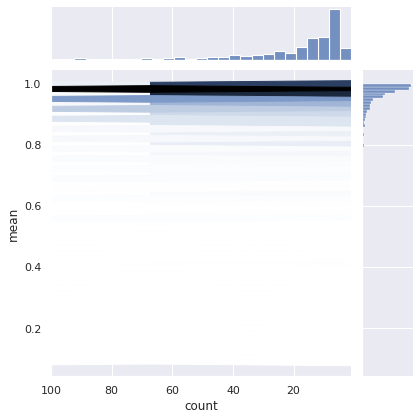

In [ ]:
sns.jointplot(y_grouped_df_2['count'], y_grouped_df_2['mean'], kind='hex', xlim=100)

In [ ]:
weights = y_grouped_df_2.to_dict()['amount']

### weighted combination of models

In [ ]:
y_probs_list = [y_probs_1, y_probs_2]
y_val_probs_list = [y_val_probs_1, y_val_probs_2]

In [ ]:
class combined_model:

  def fit(self, y_probs_list, y, alpha_list=None, beta=1):#y_seq, y_cnn, y_rnn, y, alpha=.5, beta=1):

    total_sums = None
    sums_dict = {}

    for i in range(len(y_probs_list)):
      y_probs = y_probs_list[i]
      correct_probs = np.multiply(y_probs, y)
      sums_dict[i] = (correct_probs.sum(axis=0)) ** beta

      if total_sums is None:
        total_sums = sums_dict[i]
      else:
        total_sums = total_sums + sums_dict[i]

    if alpha_list is None:
      alpha_list = [1.0/len(y_probs_list)] * len(y_probs_list)

    self.weights = {}
    default_alpha = 1.0/len(y_probs_list)

    for i in range(len(y_probs_list)):
      self.weights[i] = alpha_list[i] / default_alpha * sums_dict[i] / total_sums

    # correct_probs_seq = np.multiply(y_seq, y)
    # correct_probs_cnn = np.multiply(y_cnn, y)
    # correct_probs_rnn = np.multiply(y_cnn, y)

    # sums_seq = (correct_probs_seq.sum(axis=0)) ** beta
    # sums_cnn = (correct_probs_cnn.sum(axis=0)) ** beta
    # sums_rnn = (correct_probs_rnn.sum(axis=0)) ** beta

    # self.weights_seq = (alpha/.5) * sums_seq / (sums_seq + sums_cnn)
    # self.weights_cnn = ((1 - alpha)/.5) *sums_cnn / (sums_seq + sums_cnn)

  def evaluate(self, y_probs_list, y):#y_seq, y_cnn, y):

    y_probs = None
    for i in range(len(y_probs_list)):
      if y_probs is None:
        y_probs = np.multiply(y_probs_list[i], self.weights[i])
      else:
        y_probs = y_probs + np.multiply(y_probs_list[i], self.weights[i])

    #y_probs = np.multiply(y_seq, self.weights_seq) + np.multiply(y_cnn, self.weights_cnn)
    y_probs = y_probs/y_probs.sum(axis=1)[:,None]

    top10_idx = np.argpartition(y_probs, -10, axis=1)[:, -10:]
    y_idx = np.argpartition(y, -1, axis=1)[:, -1:]
    top_10_accuracy = (top10_idx == y_idx).any(axis=1).mean()

    return top_10_accuracy

  def predict(self, y_probs_list):#y_seq, y_cnn):

    y_probs = None
    for i in range(len(y_probs_list)):
      if y_probs is None:
        y_probs = np.multiply(y_probs_list[i], self.weights[i])
      else:
        y_probs = y_probs + np.multiply(y_probs_list[i], self.weights[i])
    # y_probs = np.multiply(y_seq, self.weights_seq) + np.multiply(y_cnn, self.weights_cnn)
    y_probs = y_probs/y_probs.sum(axis=1)[:,None]

    return y_probs

  def fit_evaluate(self, y_probs_list, y, y_val_probs_list, y_val, alpha_list, beta):#y_seq, y_cnn, y, y_val_seq, y_val_cnn, y_val, alpha, beta):

    self.fit(y_probs_list, y, alpha_list, beta)#y_seq, y_cnn, y, alpha, beta)

    return self.evaluate(y_val_probs_list, y_val)#y_val_seq, y_val_cnn, y_val)

  def tune(self,
           y_probs_list, y, y_val_probs_list, y_val, 
           alpha_1_range=np.linspace(0.45,.66,33), 
           alpha_2_range=np.linspace(0.15,.33,33), 
           beta_range=np.linspace(1,15,15)):#alpha_range=np.linspace(0.2,.8,60), beta_range=np.linspace(1,50,25), y_seq=y_probs_seq, y_cnn=y_probs_cnn, y=y, y_val_seq=y_val_probs_seq, y_val_cnn=y_val_probs_cnn, y_val=y_val):


    results_dict = {}
    for alpha_1 in alpha_1_range:
      for alpha_2 in alpha_2_range:
        for beta in beta_range:
          results_dict['alpha_1'] = alpha_1
          print(alpha_1)
          results_dict['alpha_2'] = alpha_2
          print(alpha_2)
          alpha_3 = 1 - alpha_1 - alpha_2
          results_dict['alpha_3'] = alpha_3
          print(alpha_3)
          results_dict['beta'] = beta
          print(beta)

          result = model.fit_evaluate(y_probs_list, y, y_val_probs_list, y_val, 
                                      [alpha_1, alpha_2, alpha_3], beta)

          results_dict['result'] = result
          print('result {}'.format(result))

    return results_dict

    # top_10_accuracy_list = []
    # for alpha in alpha_range:
    #   print(alpha)
    #   self.fit(y_seq, y_cnn, y, alpha)
    #   top_10_accuracy_list.append(self.evaluate(y_seq, y_cnn, y))

    # arg_max = np.argmax(top_10_accuracy_list)

    # return alpha_range[arg_max]


In [ ]:
model = combined_model()
model.fit(y_probs_list, y, alpha_list=[.8,.2],beta=5)
model.evaluate(y_val_probs_list, y_val)

0.9235956839098699

# Load Tuning Data

In [ ]:
import os
import json
import kerastuner.engine.hyperparameters as hp_module
import kerastuner.engine.trial as trial_module
import kerastuner.engine.metrics_tracking as metrics_tracking
from kerastuner.abstractions.tensorflow import TENSORFLOW_UTILS as tf_utils
import tensorflow as tf
from tensorflow.keras.models import model_from_json

class SearchResults(object):
    def __init__(self, directory, project_name, objective):
        self.directory = directory
        self.project_name = project_name
        self.objective = objective
        
    def reload(self):
        """Populate `self.trials` and `self.oracle` state."""
        fname = os.path.join(self.directory, self.project_name, 'tuner.json')
        state_data = tf_utils.read_file(fname)
        state = json.loads(state_data)

        self.hyperparameters = hp_module.HyperParameters.from_config(
            state['hyperparameters'])
        self.best_metrics = metrics_tracking.MetricsTracker.from_config(
            state['best_metrics'])
        self.trials = [trial_module.Trial.load(f) for f in state['trials']]
        self.start_time = state['start_time']
    
    def _get_best_trials(self, num_trials=1):
        if not self.best_metrics.exists(self.objective):
            return []
        trials = []
        for x in self.trials:
            if x.score is not None:
                trials.append(x)
        if not trials:
            return []
        direction = self.best_metrics.directions[self.objective]
        sorted_trials = sorted(trials,
                               key=lambda x: x.score,
                               reverse=direction == 'max')
        return sorted_trials[:num_trials]
    
    def get_best_models(self, num_models = 1):
        best_trials = self._get_best_trials(num_models)
        models = []
        for trial in best_trials:
            hp = trial.hyperparameters.copy()
            # Get best execution.
            direction = self.best_metrics.directions[self.objective]
            executions = sorted(
                trial.executions,
                key=lambda x: x.per_epoch_metrics.get_best_value(
                    self.objective),
                reverse=direction == 'max')
            
            # Reload best checkpoint.
            ckpt = executions[0].best_checkpoint
            model_graph = ckpt + '-config.json'
            model_wts = ckpt + '-weights.h5'
            with open(model_graph, 'r') as f:
                model = model_from_json(f.read())
            model.load_weights(model_wts)
            models.append(model)
        return models

### single model

In [ ]:
model = tf.keras.models.load_model('{}/models/model_pca'.format(DATA_DIR),
                                               compile=True)

In [ ]:
probas = model.predict_proba(X_test_scaled)
probas

## submission

In [ ]:
submission_format = pd.read_csv(DATA_DIR / 'submissions/submission_format.csv', index_col='sequence_id')

In [ ]:
submission_format.shape

In [ ]:
submission_format.head()

In [ ]:
assert submission_format.shape == probas.shape
# assert (rf.classes_ == submission_format.columns).all()

In [ ]:
my_submission = pd.DataFrame(data=probas, 
                             columns=submission_format.columns, 
                             index=submission_format.index)
my_submission.head(25)

In [ ]:
my_submission.shape

In [ ]:
my_submission.sum(axis=1)

In [ ]:
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

In [ ]:
my_submission.to_csv(DATA_DIR / 'submissions/{}_submission.csv'.format(timestamp))
my_submission.to_csv(DATA_DIR / 'submissions/latest_submission.csv')